# 2. iCAPS Timecourses' statistics

In [1]:
from src import *
import scipy
from matplotlib import cm

## Table of Contents
- [iCAPS Statistics](#emotion)
    - Individual
    - Group

## Description

After being given set of temporally overlapping spatial components (iCAPS) we look into the corresponding timecourses. We then extract first level statistics of such timecourses matching icaps.

GOAL: Extract relevant statistics of iCAPS apparition (fixed number of iCAPS being 20)

In [630]:
root = '/media/miplab-nas2/Data2/Movies_Emo/Michael/DATA/fmri_tcs/'
ids = [file for file in os.listdir(root) if 'sub' in file]

clust_roots = ['iCAPs_results/iCAPS_Emo_Movies_{}_Alpha_5_95_Fraction_0DOT05/'.format(_id) for _id in ids]
ncaps = 20
# tc_dct = loadmat(root + clust_roots[4] + 'K_20_Dist_cosine_Folds_10/TC_1DOT4.mat')
# tc_stats_dct = loadmat(root + clust_roots[4] + 'K_20_Dist_cosine_Folds_10/TC_stats_1DOT4.mat')

In [339]:
# # ids = [file for file in os.listdir(root) if 'sub' in file]

# # list all pathings
# _dir = "/media/miplab-nas2/Data2/Movies_Emo/Michael/DATA/fmri_tcs/"

# _all = []
# for ID in ids:
#     try :
#         o_f = os.path.join(_dir,f"{ID}/**/*.feat/filtered_func_data_res.nii.gz")
#         o_f = glob.glob(o_f, recursive=True)
#         for k in range(len(o_f)):
#             _all.append('/'.join(o_f[k].split('/')[:-1]) +'/')
#         print(o_f)
#     except:
#         print("Something went wrong with file reading")


# dct = {}
# for I in _all:
#     nifti = nib.load(I+'/filtered_func_data_res.nii.gz')
#     splits = I.split('/')
#     keyA = splits[-4]
#     keyB = splits[-3]
#     keyC = splits[-2].split('_')[-1][:-5]
#     dct[(keyA,keyB,keyC)] = nifti.shape[-1]

# inv_dct = {ID: {} for ID in ids}
# for k in dct:
#     _id,ses,movie = k
#     inv_dct[_id][dct[k]] = movie
    
# save('./resources/run_length.pkl', [dct,inv_dct])

In [125]:
run2length, length2run = load('./resources/run_length.pkl')

In [628]:
timecourse_char = []
labels = []
for idx in range(len(clust_roots)):
    labels.append(ids[idx])
    if os.path.exists(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1DOT4.mat'):
        tmp = loadmat(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1DOT4.mat')['tempChar'][0][0]
    elif os.path.exists(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1DOT2.mat'):
        tmp = loadmat(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1DOT2.mat')['tempChar'][0][0]
    elif os.path.exists(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1.mat'):
        tmp = loadmat(root + clust_roots[idx] + 'K_20_Dist_cosine_Folds_10/tempChar_1.mat')['tempChar'][0][0]
    timecourse_char.append(tmp)
    
timecourse_char = np.stack(timecourse_char)

In [629]:
len(timecourse_char)

14

## iCAPS Statistics


### Individual: Statistics to extract from the iCAPS per Subject

- Count of time an iCAPS appears
- Count number of co-pattern of iCAPS 
- Count number of iCAPS appearing as a function of TR
- Count number of an iCAPS appears (in terms of transition, so a continuous icaps is counted as 1 appearance) 

In [204]:
sidx = 1
properties = timecourse_char[sidx]
len(properties)

36

In [205]:
# Basic values of iCAPS timecourses
tc_norm_thes = properties[4][0]
tc_active = properties[5][0]
nb_coactive_time = properties[6][0]

# How many times a icaps appear during the movie (as a percentage)
ratio_active_icaps = properties[13]
ratio_pactive_icaps = properties[14]
ratio_nactive_icaps = properties[15]

# coupling counts
coupling_count = properties[22]
coupling_countratio = properties[23] # divided by either icaps being activated
diffsign_coupling_count = properties[29]
samesign_coupling_count = properties[28]

# index 24-27 useless and index 30-34 are for jaccard index if needed

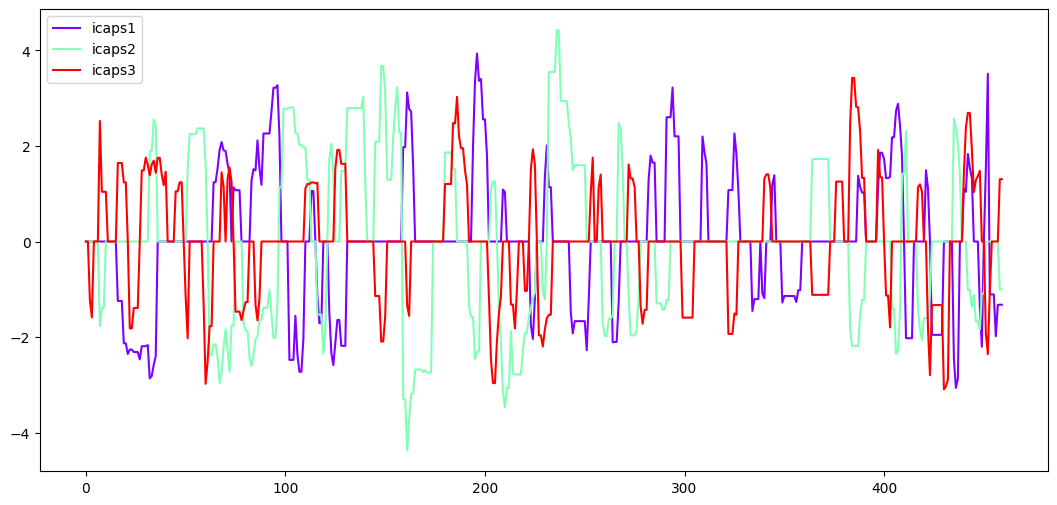

In [206]:
plt.figure(figsize=(13,6))
colors = cm.rainbow(np.linspace(0, 1, 3))
for k in range(3):
    plt.plot(tc_norm_thes[0][k], color=colors[k], label='icaps{}'.format(k+1))
    
plt.legend()

Hungarian matching to match the length of the timecourses with the name of the film

In [207]:
import numpy as np
from scipy.optimize import linear_sum_assignment

In [208]:
lengthmatch = length2run[ids[sidx]]

fmri_trs = []
for k in range(len(nb_coactive_time)):
    L = nb_coactive_time[k].shape[1]
    fmri_trs.append(L)

# Compute the cost matrix
cost_matrix = np.zeros((len(fmri_trs),len(fmri_trs)))
A = fmri_trs
B = list(lengthmatch.keys())
# When Rest is of same length as other series
if len(B) == 14: B.append(460)

for k in range(len(A)):
    for j in range(len(B)):
        cost_matrix[k,j] = (A[k] - B[j])**2

row_indices, col_indices = linear_sum_assignment(cost_matrix)
assignment = [(row, col) for row, col in zip(row_indices, col_indices)]


labels = list(lengthmatch.values())
if len(labels) == 14: labels +=  ['Rest']
ordered_movies = []
for k in range(len(fmri_trs)):
    ordered_movies.append(labels[assignment[k][1]])

#### Number of simultaneous active iCAPS across films and rest

In [357]:
nb_coactives = np.concatenate([nb_coactive_time[k][0] for k in range(len(nb_coactive_time))])
tmp = np.concatenate([nb_coactive_time[k][0].shape for k in range(len(nb_coactive_time))])
movienames = np.concatenate([[ordered_movies[t]] * tmp[t] for t in range(len(tmp))])

<Axes: >

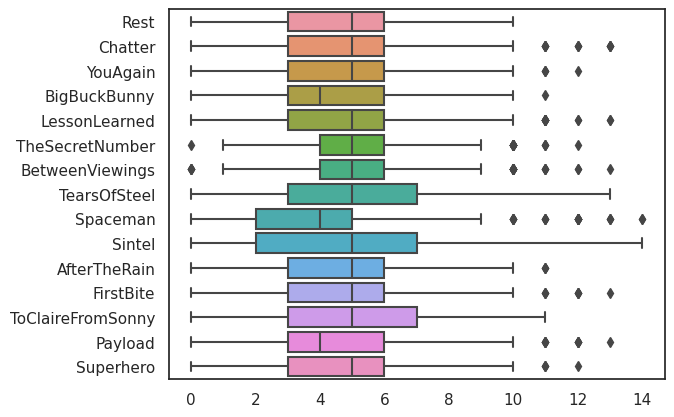

In [358]:
df = {'nb_coactive': nb_coactives, 'moviename': movienames}
sns.boxplot(data=df, x="nb_coactive", y="moviename")

#### Ratio of each iCAPS in the timecourse across films and rest

In [362]:
df1 = {'moviename': ordered_movies }
df2 = {'moviename': ordered_movies }
df3 = {'moviename': ordered_movies }
for k in range(15):
    tmp1 = ratio_active_icaps[:,k]
    tmp2 = ratio_pactive_icaps[:,k]
    tmp3 = ratio_nactive_icaps[:,k]    
    for j in range(20):
        if ('icaps{}'.format(j+1)) not in df1 :
            df1['icaps{}'.format(j+1)] = [tmp1[j]/100]
            df2['icaps{}'.format(j+1)] = [tmp2[j]/100]
            df3['icaps{}'.format(j+1)] = [tmp3[j]/100]            
        else:
            df1['icaps{}'.format(j+1)].append(tmp1[j]/100)
            df2['icaps{}'.format(j+1)].append(tmp2[j]/100)
            df3['icaps{}'.format(j+1)].append(tmp3[j]/100)            
            
df1 = pd.DataFrame.from_dict(df1)
df2 = pd.DataFrame.from_dict(df2)
df3 = pd.DataFrame.from_dict(df3)

<Axes: title={'center': 'Negative Active Icaps Ratios across different movies'}, xlabel='moviename'>

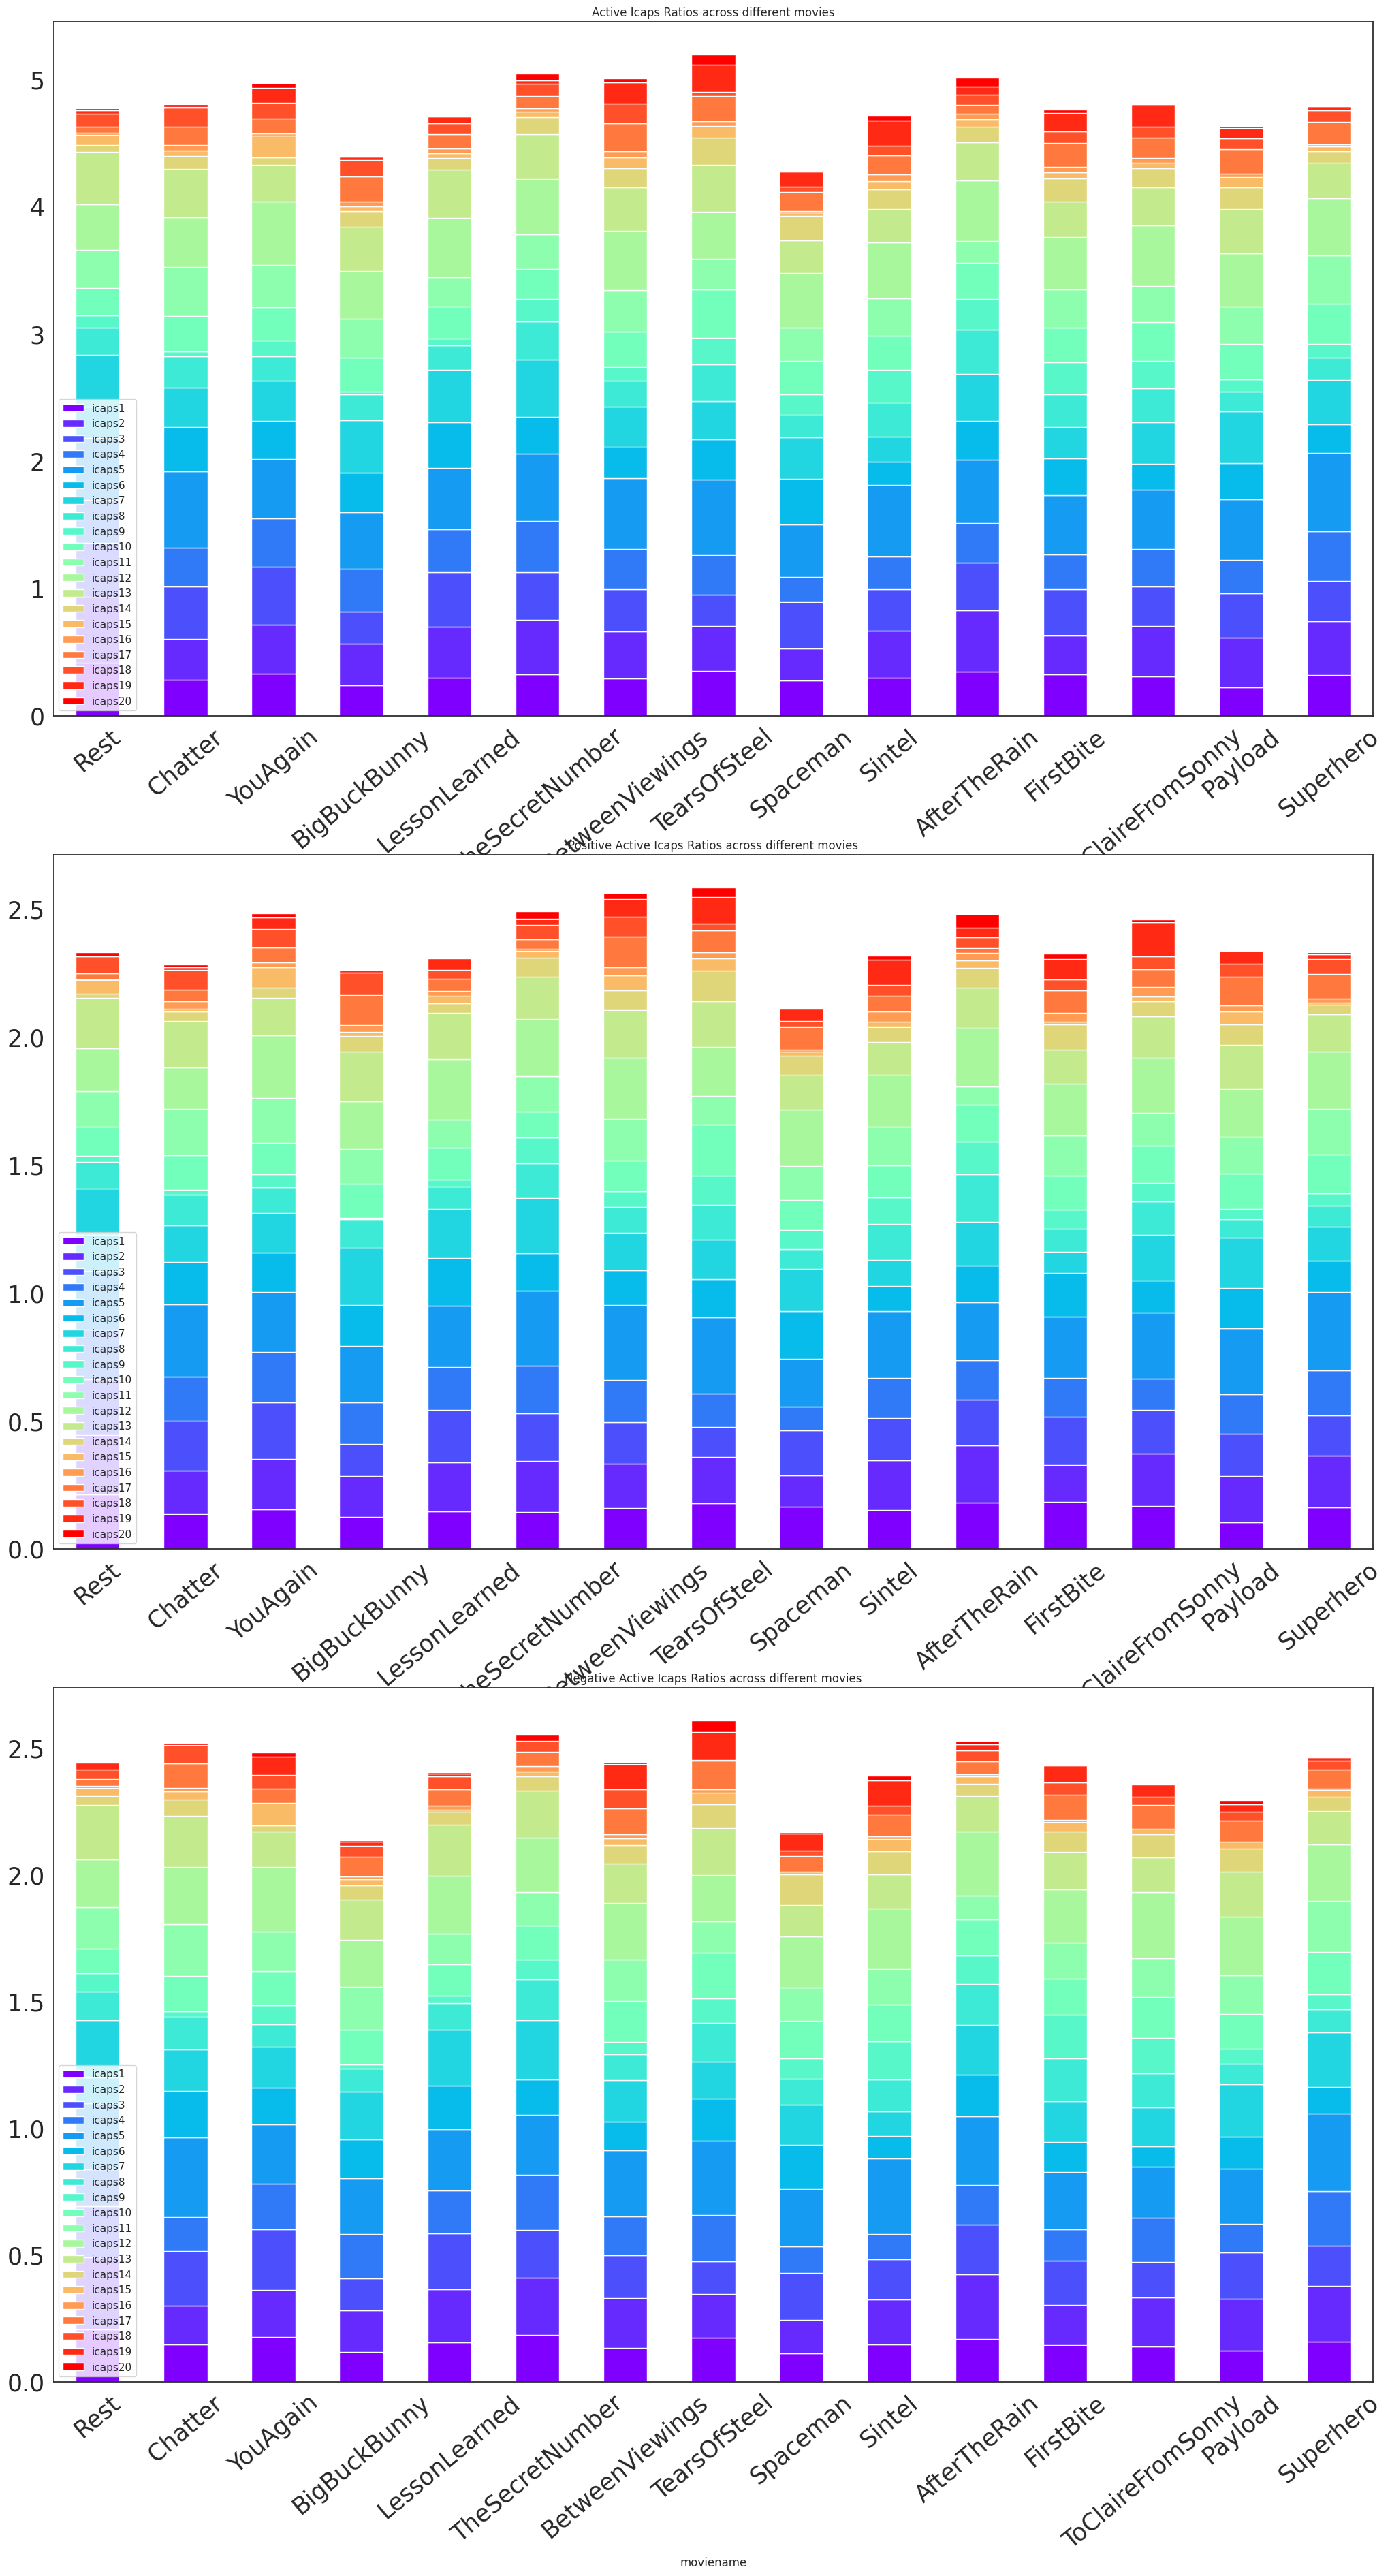

In [363]:
fig, ax = plt.subplots(3, figsize=(25,45))
colors = cm.rainbow(np.linspace(0, 1, len(ratio_active_icaps)))
df1.plot.bar(x='moviename', stacked=True, title='Active Icaps Ratios across different movies', 
            ax=ax[0], color=colors, fontsize=25,rot=40)

df2.plot.bar(x='moviename', stacked=True, title='Positive Active Icaps Ratios across different movies', 
            ax=ax[1], color=colors, fontsize=25,rot=40)

df3.plot.bar(x='moviename', stacked=True, title='Negative Active Icaps Ratios across different movies', 
            ax=ax[2], color=colors, fontsize=25,rot=40)

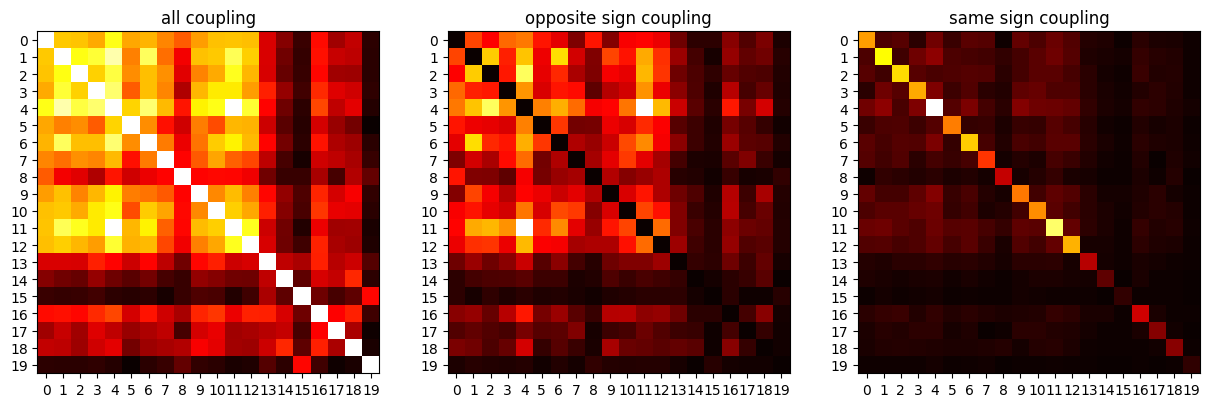

In [214]:
# Average coupling on the 15 movies between icaps
fig, ax = plt.subplots(1,3,figsize=(15,5)) 
ax[0].imshow(coupling_countratio.mean(axis=-1), cmap='hot')
ax[0].set_xticks(np.arange(20)) 
ax[0].set_yticks(np.arange(20)) 
ax[0].set_title('all coupling')


ax[1].imshow(diffsign_coupling_count.mean(axis=-1), cmap='hot')
ax[1].set_xticks(np.arange(20)) 
ax[1].set_yticks(np.arange(20))
ax[1].set_title('opposite sign coupling')

ax[2].imshow(samesign_coupling_count.mean(axis=-1), cmap='hot')
ax[2].set_xticks(np.arange(20)) 
ax[2].set_yticks(np.arange(20))
ax[2].set_title('same sign coupling')
plt.show()

#### Duration of a consecutive iCAPS and number of discontinuous iCAPS

In [239]:
import itertools
def consecutive_onescount(array):
    return [ sum( 1 for _ in group ) for key, group in itertools.groupby( array ) if key ]

In [255]:
rest_consecutive = np.zeros(20)
film_consecutive = []
rest_ccount = np.zeros(20)
film_ccount = []

for nicap in range(20):
    movie_tmp = []
    movie_ctmp = []
    for k in range(15):
        if ordered_movies[k] == 'Rest':
            rest_consecutive[nicap] = np.mean(consecutive_onescount(tc_active[k][nicap]))
            rest_ccount[nicap] = len(consecutive_onescount(tc_active[k][nicap]))
        else:
            movie_tmp.append(np.mean(consecutive_onescount(tc_active[k][nicap])))
            movie_ctmp.append(len(consecutive_onescount(tc_active[k][nicap])))
    film_consecutive.append(movie_tmp)
    film_ccount.append(movie_ctmp)
    
film_consecutive = np.asarray(film_consecutive)
film_ccount = np.asarray(film_ccount)

In [364]:
cur_df = {'icaps': [], 'corr': [], 'type': []}

for k in range(20):
    cur_df['corr'] += list(film_consecutive[k])
    cur_df['icaps'] += len(list(film_consecutive[k])) * ['icaps{}'.format(k+1)]
    cur_df['type'] += ['film'] * len(list(film_consecutive[k]))

cur_df['corr'] += list(rest_consecutive)
cur_df['icaps'] += ['icaps{}'.format(k) for k in np.arange(1,21)]
cur_df['type'] += ['rest'] * 20

# create small box
cur_df['corr'] += list(rest_consecutive + .2)
cur_df['icaps'] += ['icaps{}'.format(k) for k in np.arange(1,21)]
cur_df['type'] += ['rest'] * 20

cur_df = pd.DataFrame.from_dict(cur_df)

('icaps1', 'films') ('icaps1', 'films') 0.14724970074611035
('icaps2', 'films') ('icaps2', 'films') 0.02041747439057595
('icaps3', 'films') ('icaps3', 'films') 0.6115152829930863
('icaps4', 'films') ('icaps4', 'films') 0.527726085788391
('icaps5', 'films') ('icaps5', 'films') 0.26657513687578754
('icaps6', 'films') ('icaps6', 'films') 0.35165217601330323
('icaps7', 'films') ('icaps7', 'films') 0.8591550444695505
('icaps8', 'films') ('icaps8', 'films') 0.8712689196188936
('icaps9', 'films') ('icaps9', 'films') 0.8946196710679242
('icaps10', 'films') ('icaps10', 'films') 0.7063261202799989
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

icaps2_film vs. icaps2_rest: Custom statistical test, P_val:2.042e-02


/home/chchan/miniconda3/envs/icaps_movies/lib/python3.8/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


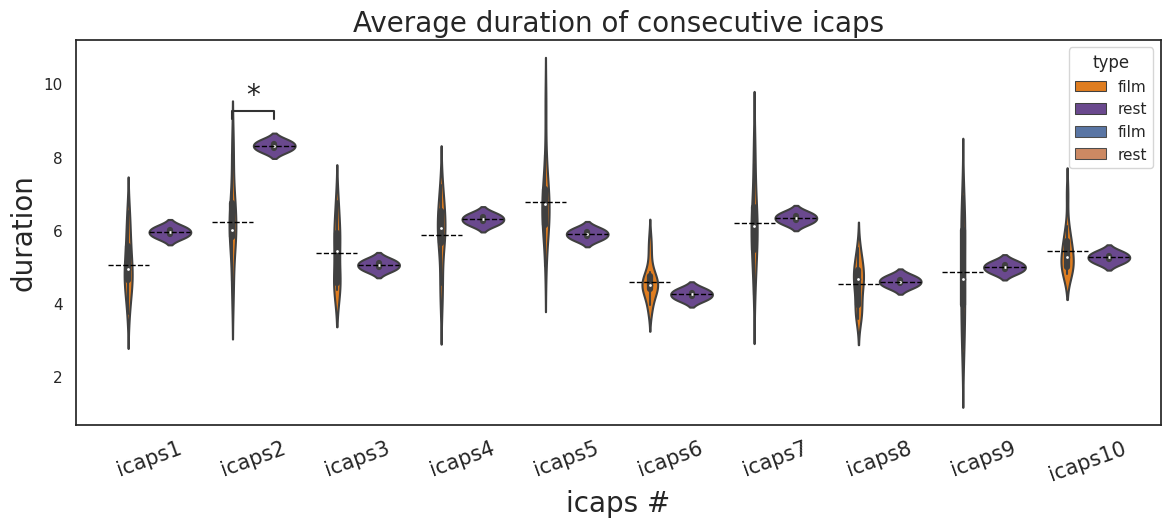

('icaps11', 'films') ('icaps11', 'films') 0.9063029255242343
('icaps12', 'films') ('icaps12', 'films') 0.05044359466088734
('icaps13', 'films') ('icaps13', 'films') 0.6670091655296817
('icaps14', 'films') ('icaps14', 'films') 0.056053095016718554
('icaps15', 'films') ('icaps15', 'films') 0.07929520532568031
('icaps16', 'films') ('icaps16', 'films') 0.05891200207762082
('icaps17', 'films') ('icaps17', 'films') 0.03858032649760824
('icaps18', 'films') ('icaps18', 'films') 0.011862120773102147
('icaps19', 'films') ('icaps19', 'films') 0.3588498016706059
('icaps20', 'films') ('icaps20', 'films') 0.6745632924805799
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

icaps17_film vs. icaps17_rest: Custom statistical test, P_val:3.858e-02


/home/chchan/miniconda3/envs/icaps_movies/lib/python3.8/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


icaps18_film vs. icaps18_rest: Custom statistical test, P_val:1.186e-02


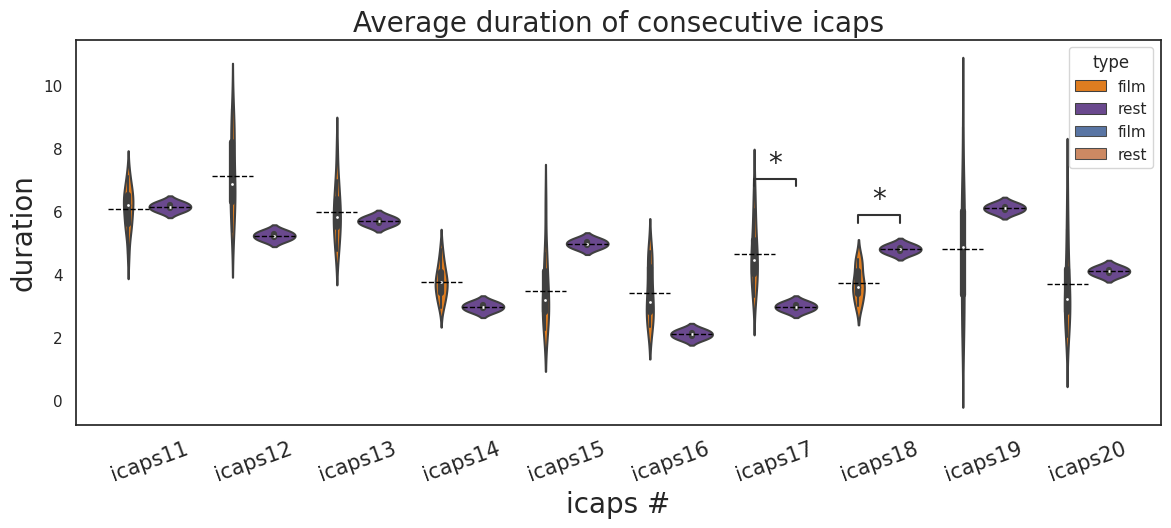

In [365]:
# it seems like count separates
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set_theme(style='white')

arr1 = ['icaps{}'.format(k) for k in range(1,11)]
arr2 = ['icaps{}'.format(k) for k in range(11,21)]

tmp_psy = [arr1,arr2]
for i in range(2):
    plt.figure(figsize=(14,5))

    p = sns.violinplot(x="icaps", y="corr", data=cur_df[cur_df['icaps'].isin(tmp_psy[i])], hue="type",
                  color="r", alpha=1, size=2, dodge=True, palette=sns.color_palette([
                      sns.color_palette("bright")[1], 
                  sns.color_palette("Paired")[9]]))

    # plot the mean line
    sns.boxplot(showmeans=True,meanline=True,medianprops={'visible': False},
                whiskerprops={'visible': False},zorder=10,x="icaps",y="corr", hue="type",
                data=cur_df[cur_df['icaps'].isin(tmp_psy[i])],
                showfliers=False,showbox=False,showcaps=False,ax=p, meanprops=dict(color="black", alpha=1))

    plotting_parameters = {'data':    cur_df[cur_df['icaps'].isin(tmp_psy[i])],'x':'icaps',
                           'y':'corr','hue':'type',
                           'palette': sns.color_palette([sns.color_palette("bright")[1]
                                     ,sns.color_palette("Paired")[9]])}
    
    pvalues = []
    pairs = []
    for psy_p in tmp_psy[i]:
        tmp = cur_df[cur_df['icaps'] == psy_p]
        arr1 = np.nan_to_num(list(tmp[tmp['type']=='film']['corr']))
        arr2 = np.nan_to_num(list(tmp[tmp['type']=='rest']['corr']))

        # paired t-test
        pval = stats.ttest_ind(arr1, arr2).pvalue

        print((psy_p,'films'), (psy_p, 'films'), pval)
        if pval >= 0.05: continue
        pvalues.append(pval)
        pairs.append(((psy_p,'film'), (psy_p, 'rest')))

    annotator = Annotator(p, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.configure(loc='inside', fontsize=20)
    annotator.annotate()
    
    p.set_ylabel('duration', fontsize=20)
    p.set_xlabel('icaps #', fontsize=20)
    p.set_xticklabels(tmp_psy[i], fontsize=15,rotation=20)

    plt.title("Average duration of consecutive icaps", fontsize=20)
    plt.show()

In [342]:
cur_df = {'icaps': [], 'corr': [], 'type': []}

for k in range(20):
    cur_df['corr'] += list(film_ccount[k])
    cur_df['icaps'] += len(list(film_ccount[k])) * ['icaps{}'.format(k+1)]
    cur_df['type'] += ['film'] * len(list(film_ccount[k]))

cur_df['corr'] += list(rest_ccount)
cur_df['icaps'] += ['icaps{}'.format(k) for k in np.arange(1,21)]
cur_df['type'] += ['rest'] * 20

# create small box
cur_df['corr'] += list(rest_ccount + 2)
cur_df['icaps'] += ['icaps{}'.format(k) for k in np.arange(1,21)]
cur_df['type'] += ['rest'] * 20

cur_df = pd.DataFrame.from_dict(cur_df)

('icaps1', 'films') ('icaps1', 'films') 0.36614473857999896
('icaps2', 'films') ('icaps2', 'films') 0.19520565639937282
('icaps3', 'films') ('icaps3', 'films') 0.6105428769727855
('icaps4', 'films') ('icaps4', 'films') 0.14757966772730696
('icaps5', 'films') ('icaps5', 'films') 0.21606568592043185
('icaps6', 'films') ('icaps6', 'films') 0.052072664781885464
('icaps7', 'films') ('icaps7', 'films') 0.44382639357575815
('icaps8', 'films') ('icaps8', 'films') 0.034487100714646446
('icaps9', 'films') ('icaps9', 'films') 0.12152211300289875
('icaps10', 'films') ('icaps10', 'films') 0.019252579578577487
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

icaps10_film vs. icaps10_rest: Custom statistical test, P_val:1.925e-02


/home/chchan/miniconda3/envs/icaps_movies/lib/python3.8/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


icaps8_film vs. icaps8_rest: Custom statistical test, P_val:3.449e-02


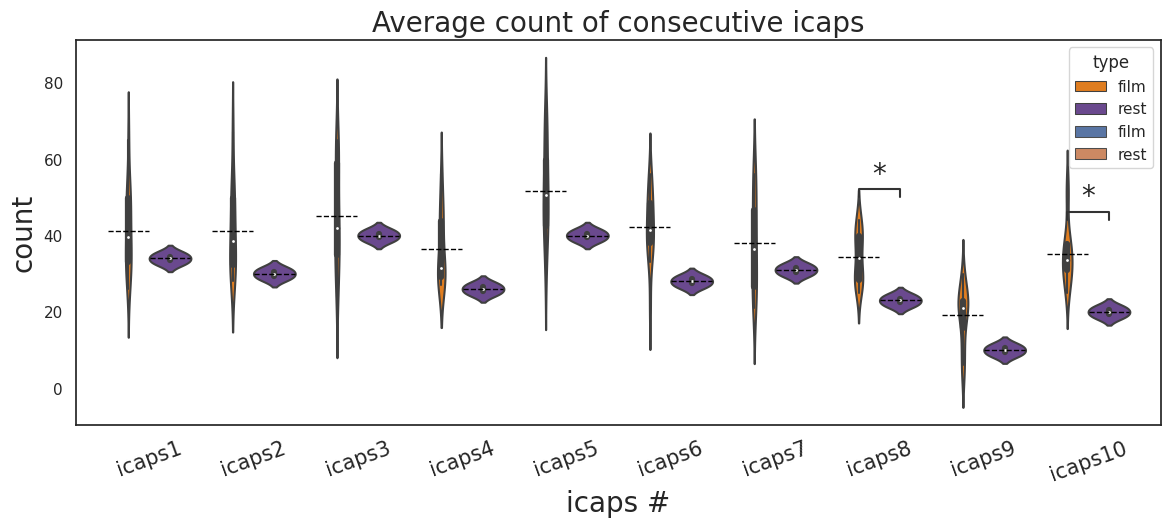

('icaps11', 'films') ('icaps11', 'films') 0.2600235624788592
('icaps12', 'films') ('icaps12', 'films') 0.27558010332199073
('icaps13', 'films') ('icaps13', 'films') 0.7840809567381855
('icaps14', 'films') ('icaps14', 'films') 0.02825593060791177
('icaps15', 'films') ('icaps15', 'films') 0.4506510622310004
('icaps16', 'films') ('icaps16', 'films') 0.11587351850608654
('icaps17', 'films') ('icaps17', 'films') 0.03594408563541454
('icaps18', 'films') ('icaps18', 'films') 0.26012271970133705
('icaps19', 'films') ('icaps19', 'films') 0.06590765005825236
('icaps20', 'films') ('icaps20', 'films') 0.4232295762802277
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

icaps14_film vs. icaps14_rest: Custom statistical test, P_val:2.826e-02


/home/chchan/miniconda3/envs/icaps_movies/lib/python3.8/site-packages/statannotations/Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


icaps17_film vs. icaps17_rest: Custom statistical test, P_val:3.594e-02


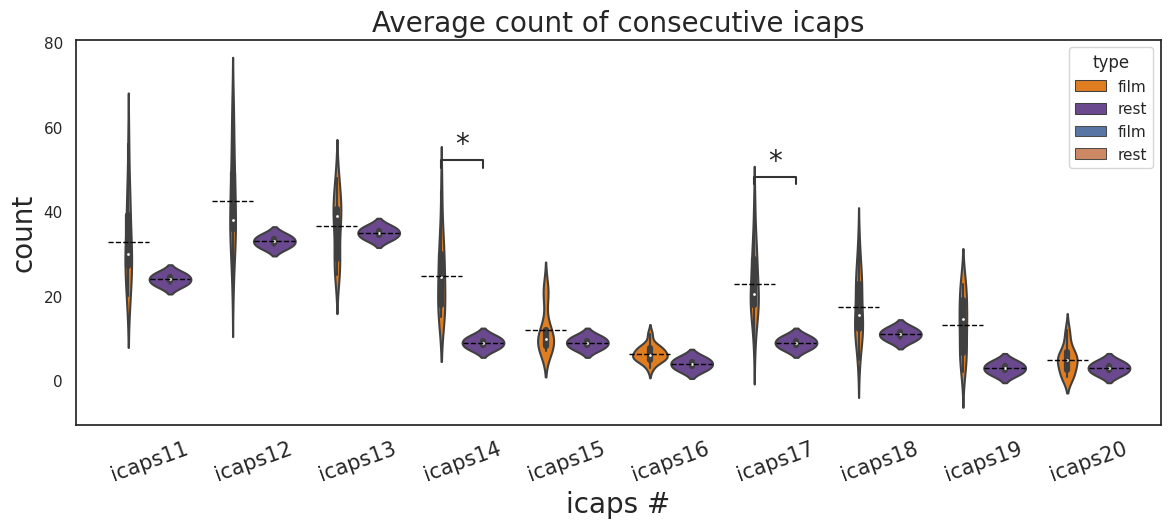

In [343]:
# it seems like count separates
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set_theme(style='white')

arr1 = ['icaps{}'.format(k) for k in range(1,11)]
arr2 = ['icaps{}'.format(k) for k in range(11,21)]

tmp_psy = [arr1,arr2]
for i in range(2):
    plt.figure(figsize=(14,5))

    p = sns.violinplot(x="icaps", y="corr", data=cur_df[cur_df['icaps'].isin(tmp_psy[i])], hue="type",
                  color="r", alpha=1, size=2, dodge=True, palette=sns.color_palette([
                      sns.color_palette("bright")[1], 
                  sns.color_palette("Paired")[9]]))

    # plot the mean line
    sns.boxplot(showmeans=True,meanline=True,medianprops={'visible': False},
                whiskerprops={'visible': False},zorder=10,x="icaps",y="corr", hue="type",
                data=cur_df[cur_df['icaps'].isin(tmp_psy[i])],
                showfliers=False,showbox=False,showcaps=False,ax=p, meanprops=dict(color="black", alpha=1))

    plotting_parameters = {'data':    cur_df[cur_df['icaps'].isin(tmp_psy[i])],'x':'icaps',
                           'y':'corr','hue':'type',
                           'palette': sns.color_palette([sns.color_palette("bright")[1]
                                     ,sns.color_palette("Paired")[9]])}
    
    pvalues = []
    pairs = []
    for psy_p in tmp_psy[i]:
        tmp = cur_df[cur_df['icaps'] == psy_p]
        arr1 = np.nan_to_num(list(tmp[tmp['type']=='film']['corr']))
        arr2 = np.nan_to_num(list(tmp[tmp['type']=='rest']['corr']))

        # paired t-test
        pval = stats.ttest_ind(arr1, arr2).pvalue

        print((psy_p,'films'), (psy_p, 'films'), pval)
        if pval >= 0.05: continue
        pvalues.append(pval)
        pairs.append(((psy_p,'film'), (psy_p, 'rest')))

    annotator = Annotator(p, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.configure(loc='inside', fontsize=20)
    annotator.annotate()
    
    p.set_ylabel('count', fontsize=20)
    p.set_xlabel('icaps #', fontsize=20)
    p.set_xticklabels(tmp_psy[i], fontsize=15,rotation=20)

    plt.title("Average count of consecutive icaps", fontsize=20)
    plt.show()

### Group: Statistics to extract from the iCAPS aggregating across subjects

- Synchronization of subjects (a matched iCAPS appear same time for subjects?)
- Compare counts distribution of iCAPS across subjects
- Compute a probability series of an iCAPS to appear at a given point given the population

In order to deal with group level icaps it is necessary to match the derived icaps among the various subjects.
The matching is previously done by Hungarian matching with sub-S01 as a reference for all other pair matchings.

In [338]:
ids = [file.strip('sub-') for file in os.listdir(root) if 'sub' in file]
ids = ids[:-3]

assigns = []
for k in range(len(ids)-1):
    assign = mat73.loadmat('./hungarian_match/results/assignment{}-{}.mat'.format(ids[0],ids[k+1]))['assignment']
    assigns.append(assign)
    
assigns = np.asarray(assigns, dtype=int) - 1

In [577]:
# Reorder the films because each subjects has different order of films
tc_active = []
for k in range(len(timecourse_char)):
    tmp = timecourse_char[k][5][0]
    
    
    
    lengthmatch = length2run['sub-{}'.format(ids[k])]
    fmri_trs = []
    for fidx in range(len(tmp)):
        fmri_trs.append(tmp[fidx].shape[1])

    # Compute the cost matrix
    cost_matrix = np.zeros((len(fmri_trs),len(fmri_trs)))
    A = fmri_trs
    B = list(lengthmatch.keys())
    # When Rest is of same length as other series
    if len(B) == 14: B.append(460)

    for row in range(len(A)):
        for col in range(len(B)):
            cost_matrix[row,col] = (A[row] - B[col])**2
    
    # Solve the assignment problem
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    # Extract the optimal assignment
    assignment = [(row, col) for row, col in zip(row_indices, col_indices)]
    labels = list(lengthmatch.values())
    if len(labels) == 14: labels +=  ['Rest']
    ordered_movies = []
    for fidx in range(len(fmri_trs)):
        ordered_movies.append(labels[assignment[fidx][1]])

    reordered_films = tmp[np.argsort(ordered_movies)]
    
    # Reorder as well all the icaps so we are comparing the matched icaps between subjects
    if k == 0: 
        tc_active.append(reordered_films) # we match the icaps on the first subject
    else:
        tc_active.append([reordered_films[fidx][assigns[k-1]] for fidx in range(len(reordered_films))])

In [578]:
filmnames = list(FILM2DURATION.keys())
fa_timecourse = {}
for fname in filmnames:
    with open("./data/emo3FA/3FA13_{}_stim.tsv".format(fname)) as file:
        tsv_file = csv.reader(file, delimiter="\t")
        fa_timecourse[fname] = np.array(list(tsv_file), dtype=float).shape[0]

In [603]:
order = list(fa_timecourse.values())
order.insert(7,370)

In [604]:
cropped_array = {fidx: [] for fidx in range(15)}
for k in range(len(tc_active)):
    for fidx in range(len(tc_active[k])):
        cropped_array[fidx].append(tc_active[k][fidx][:,int(WASH):int(WASH)+order[fidx]])

In [605]:
synchro_film1 = np.abs(np.array(cropped_array[0])).mean(axis=0)
synchro_film2 = np.abs(np.array(cropped_array[3])).mean(axis=0)
synchro_rest = np.abs(np.array(cropped_array[7])).mean(axis=0)

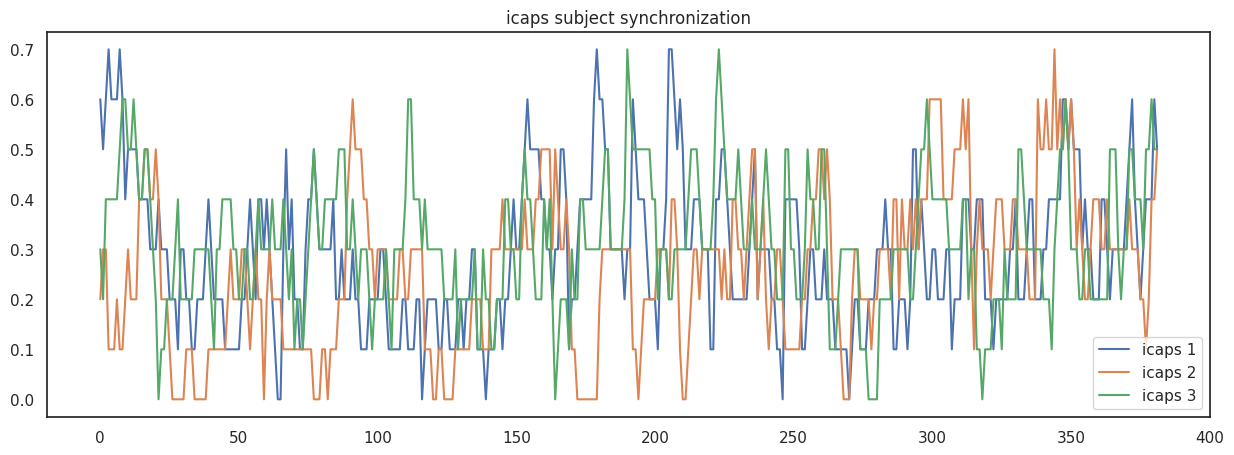

In [606]:
plt.figure(figsize=(15,5))
plt.title('icaps subject synchronization')
for k in range(3):
    plt.plot(synchro_film1[k], label='icaps {}'.format(k+1))
    
plt.legend()

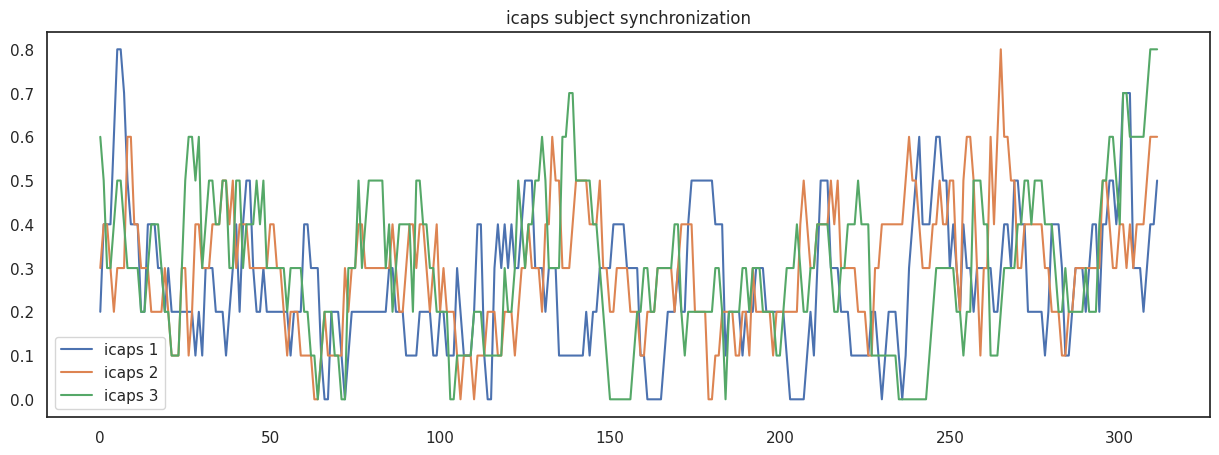

In [607]:
plt.figure(figsize=(15,5))
plt.title('icaps subject synchronization')
for k in range(3):
    plt.plot(synchro_film2[k], label='icaps {}'.format(k+1))
    
plt.legend()

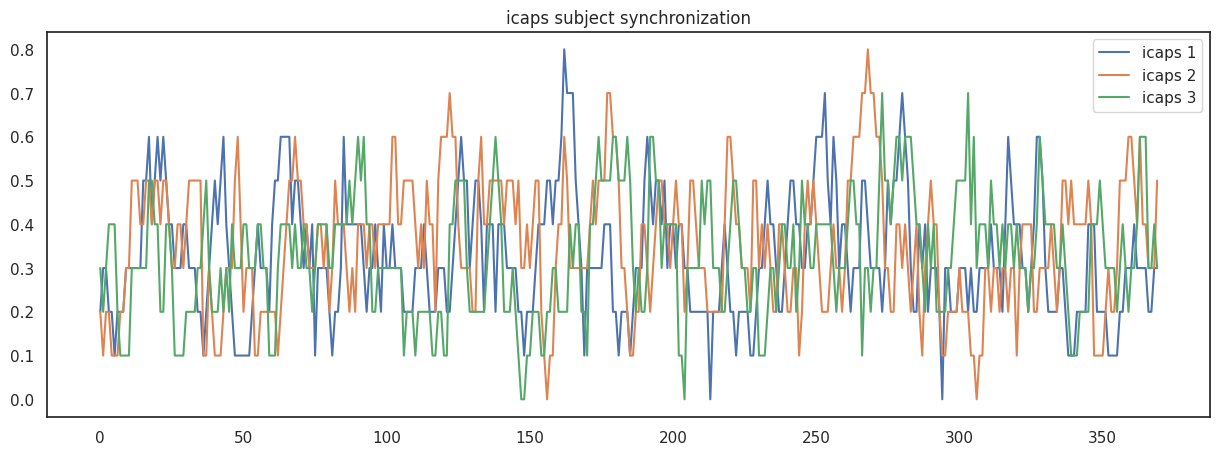

In [608]:
plt.figure(figsize=(15,5))
plt.title('icaps subject synchronization')
for k in range(3):
    plt.plot(synchro_rest[k], label='icaps {}'.format(k+1))
    
plt.legend()

In [609]:
synchro_film2.mean(axis=1)

array([0.26378205, 0.30032051, 0.30096154, 0.24423077, 0.23333333,
       0.19102564, 0.25801282, 0.21987179, 0.28365385, 0.175     ,
       0.2724359 , 0.24230769, 0.18429487, 0.18589744, 0.19903846,
       0.22147436, 0.11442308, 0.11089744, 0.1349359 , 0.18333333])

In [610]:
synchro_rest.mean(axis=1)

array([0.32648649, 0.35216216, 0.32675676, 0.24648649, 0.27594595,
       0.30837838, 0.28162162, 0.25837838, 0.2972973 , 0.24810811,
       0.34108108, 0.25459459, 0.24783784, 0.18243243, 0.19459459,
       0.28054054, 0.06756757, 0.13675676, 0.17756757, 0.1527027 ])

In [611]:
synchro_film1.mean(axis=1)

array([0.28874346, 0.25837696, 0.31099476, 0.25890052, 0.23272251,
       0.21465969, 0.25759162, 0.23691099, 0.26649215, 0.25942408,
       0.29057592, 0.22434555, 0.20602094, 0.21256545, 0.19319372,
       0.35759162, 0.14764398, 0.12408377, 0.16780105, 0.19790576])

In [613]:
save('film-icaps-matched_timecourse.pkl',cropped_array)

In [616]:
# Reorder the films because each subjects has different order of films
tc_norm = []
for k in range(len(timecourse_char)):
    tmp = timecourse_char[k][4][0]
    
    
    
    lengthmatch = length2run['sub-{}'.format(ids[k])]
    fmri_trs = []
    for fidx in range(len(tmp)):
        fmri_trs.append(tmp[fidx].shape[1])

    # Compute the cost matrix
    cost_matrix = np.zeros((len(fmri_trs),len(fmri_trs)))
    A = fmri_trs
    B = list(lengthmatch.keys())
    # When Rest is of same length as other series
    if len(B) == 14: B.append(460)

    for row in range(len(A)):
        for col in range(len(B)):
            cost_matrix[row,col] = (A[row] - B[col])**2
    
    # Solve the assignment problem
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    # Extract the optimal assignment
    assignment = [(row, col) for row, col in zip(row_indices, col_indices)]
    labels = list(lengthmatch.values())
    if len(labels) == 14: labels +=  ['Rest']
    ordered_movies = []
    for fidx in range(len(fmri_trs)):
        ordered_movies.append(labels[assignment[fidx][1]])

    reordered_films = tmp[np.argsort(ordered_movies)]
    
    # Reorder as well all the icaps so we are comparing the matched icaps between subjects
    if k == 0: 
        tc_norm.append(reordered_films) # we match the icaps on the first subject
    else:
        tc_norm.append([reordered_films[fidx][assigns[k-1]] for fidx in range(len(reordered_films))])

In [618]:
cropped_array = {fidx: [] for fidx in range(15)}
for k in range(len(tc_norm)):
    for fidx in range(len(tc_norm[k])):
        cropped_array[fidx].append(tc_norm[k][fidx][:,int(WASH):int(WASH)+order[fidx]])

In [619]:
save('film-icaps-matched_timecourse_norm.pkl',cropped_array)